In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240717%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240717T061746Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D943e667b26ce6900b7fe4bd801d7187d5974e97116e4bb2e8098418960ed7169f18edd4408c8f723bf4d5d2239fcd7762b517947c3de1f9554c90fb0644910197f22f57f5198ab7183f81c0ebeb1930b414f24371c1427dc2fad03aa513a55ce02b05905e0d394b5ebb25d235b2f088895f92b57717b85064af21f52ffc200ff735770019f66984adb6568f678ec3cdaad5c054f12533483fc9c0f605f62bf35886bda1496e1e2e16f73123c90d10a7a87e51fa91df24cb59843357f148ca60925a682703c9353c44a9a84669b3e717fe05844f183ccf90cd6919e13797a4805b9947b7188b53eadad26aa4c36d784c01b171aa426fea31ef8d249610f117787'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
Data source import complete.


# <center>                                        Speech Emotion Recognition

### <center>                                    What is Speech Emotion Recognition?

#### Definition :

Speech emotion recognition (SER) is the field of technology focused on identifying the emotional state of a speaker from their voice.  This goes beyond the words spoken and analyzes  how they are spoken.

#### How it Works :

* **Speech Input**: Similar to standard speech recognition, the user's voice is recorded.
* **Pre-processing**: The audio is prepared by removing noise and potentially isolating specific speech segments.
* **Feature Extraction**: Crucial features related to emotions are extracted. These include:
* **Prosodic features**: Pitch, intonation, volume, speaking rate, pauses
* **Spectral Features**: Spectrum of the voice, MFCCs (emphasizing qualities similar to human perception)
* **Voice Quality Features**: Jitter, shimmer (small variations in voice quality)
* **Emotion Model**: A trained machine learning model (often using classification algorithms) takes these features and identifies the associated emotion.
* **Emotion Output**: The system outputs the detected emotion, typically with probability or confidence scores (e.g., angry, happy, sad, neutral, etc.).

#### Applications of Speech Emotion Recognition :

* **Mental Health**: Potential uses in diagnosing and monitoring mental health conditions, detecting stress or depression.
* **Customer Service**: Analyzing customer interactions in call centers to improve service and gauge satisfaction.
* **Human-Computer Interaction**: Creating more responsive and emotionally intelligent virtual assistants and robots.
* **Market Research**: Analyzing focus group responses or advertisement reception to understand emotional reactions.
* **Game Design**: Developing adaptive games that change based on a player's emotional state.

* **Dataset Used** : Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* **Overall Accuracy of this notebook** : 62.407 %

### 1. Importing Libraries

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import os
import glob
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import scipy.io.wavfile
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

### 2. Preprocessing

#### 2.1 About Dataset :

**RAVDESS** is one of the most common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
RAV = '/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)

emotion = []
gender = []
path = []
feature = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)
RAV_df.labels.value_counts()

labels
female_neutral     144
male_neutral       144
female_surprise     96
female_happy        96
female_fear         96
female_angry        96
female_disgust      96
female_sad          96
male_happy          96
male_surprise       96
male_sad            96
male_disgust        96
male_angry          96
male_fear           96
Name: count, dtype: int64

In [ ]:
display(RAV_df.head())
display(RAV_df.describe())

,emotion,labels,source,path
0,surprise,female_surprise,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
1,happy,female_happy,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
2,neutral,female_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
3,surprise,female_surprise,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,female_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...


,emotion,labels,source,path
count,1440,1440,1440,1440
unique,7,14,1,1440
top,neutral,female_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
freq,288,144,1440,1


### 3. Data Visualization :

In [ ]:
px_fig = px.histogram(RAV_df, x='emotion', color='emotion', marginal='box',
                      title='Emotion Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

px_fig = px.histogram(RAV_df, x='labels', color='emotion', marginal='box',
                      title='Label Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

In [ ]:
#Distribution of Audio File Durations
import plotly.express as px
import matplotlib.pyplot as plt

# Calculate the duration of each audio file
durations = []
for path in RAV_df.path:
    y, sr = librosa.load(path, sr=None)
    durations.append(librosa.get_duration(y=y, sr=sr))

RAV_df['duration'] = durations

# Plot the distribution of audio file durations
px_fig = px.histogram(RAV_df, x='duration', nbins=30, title='Distribution of Audio File Durations')
px_fig.update_layout(bargap=0.2)
px_fig.show()


emotion       int64
labels        int64
source       object
path         object
duration    float64
dtype: object


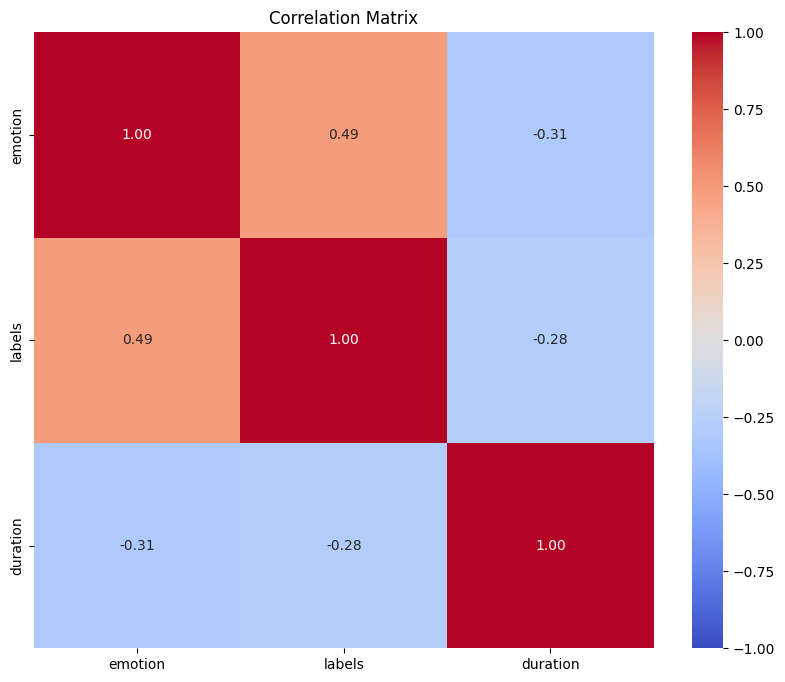

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Sample RAV_df DataFrame creation for the sake of completeness
# Convert categorical features to numerical for correlation analysis
RAV_df_num = RAV_df.copy()

# Encode 'emotion' and 'labels' columns as integers
label_encoder = LabelEncoder()
RAV_df_num['emotion'] = label_encoder.fit_transform(RAV_df_num['emotion'])
RAV_df_num['labels'] = label_encoder.fit_transform(RAV_df_num['labels'])

# Check data types to identify non-numeric columns
print(RAV_df_num.dtypes)

# Keep only numeric columns for correlation analysis
numeric_columns = RAV_df_num.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
#Feature Distribution by Emotion
import plotly.graph_objects as go

# Function to extract a single feature (mean MFCC value) for each audio file
def extract_single_feature(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=1)
    mfcc_mean = np.mean(mfcc)
    return mfcc_mean

# Extract the single feature for each audio file
single_feature = [extract_single_feature(path) for path in RAV_df.path]
RAV_df['single_feature'] = single_feature

# Plot the distribution of the feature by emotion
px_fig = px.violin(RAV_df, x='emotion', y='single_feature', color='emotion',
                   box=True, points='all', title='Distribution of Single Feature by Emotion')
px_fig.show()


In [ ]:
#Audio Duration by Emotion
# Plot the distribution of audio durations by emotion
px_fig = px.box(RAV_df, x='emotion', y='duration', color='emotion',
                title='Audio Duration by Emotion')
px_fig.show()


In [ ]:
#Count of Audio Files by Actor
# Extract actor information from the file paths
RAV_df['actor'] = RAV_df['path'].apply(lambda x: x.split('/')[-2])

# Plot the count of audio files by actor
px_fig = px.histogram(RAV_df, x='actor', color='emotion', title='Count of Audio Files by Actor')
px_fig.update_layout(bargap=0.2)
px_fig.show()


In [ ]:
#Gender Distribution by Emotion
# Extract gender information
RAV_df['gender'] = RAV_df['path'].apply(lambda x: 'male' if int(x.split('-')[6]) % 2 != 0 else 'female')

# Plot the gender distribution by emotion
px_fig = px.histogram(RAV_df, x='emotion', color='gender', barmode='group',
                      title='Gender Distribution by Emotion')
px_fig.update_layout(bargap=0.2)
px_fig.show()



In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [ ]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

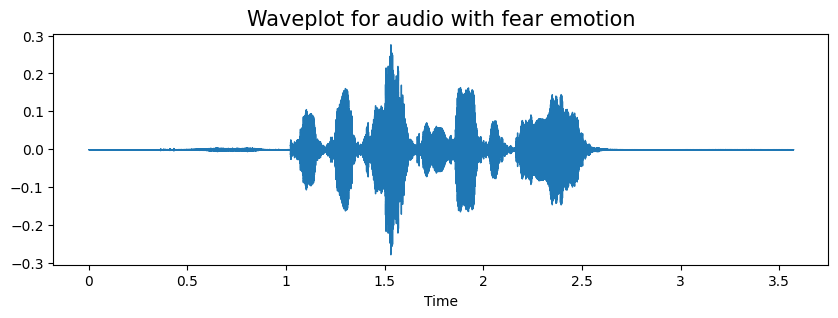

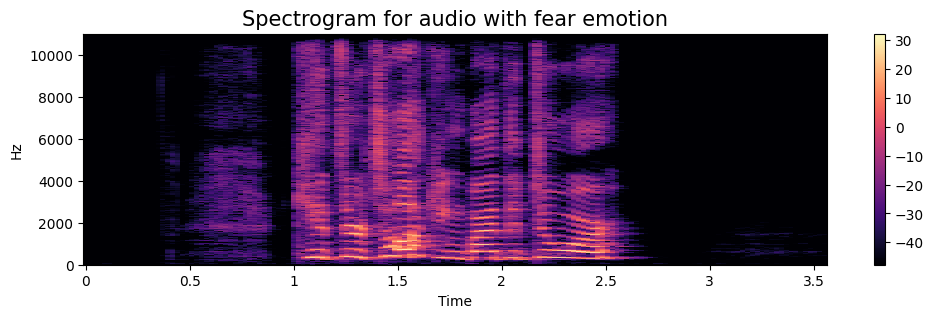

In [ ]:
emotion='fear'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

### 4. Data Augmentation :

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(RAV_df.path)[1]
data, sample_rate = librosa.load(path)

#### 4.1 Simple Audio:

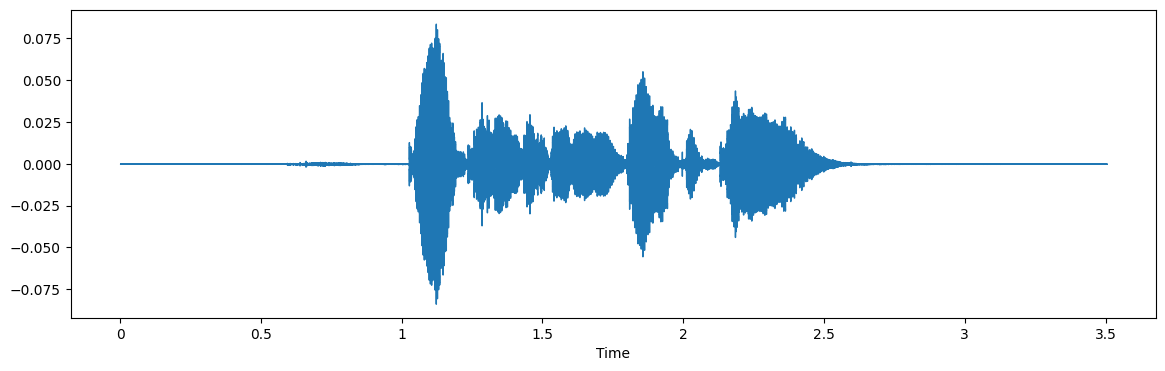

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

#### 4.2 Noise Injection :

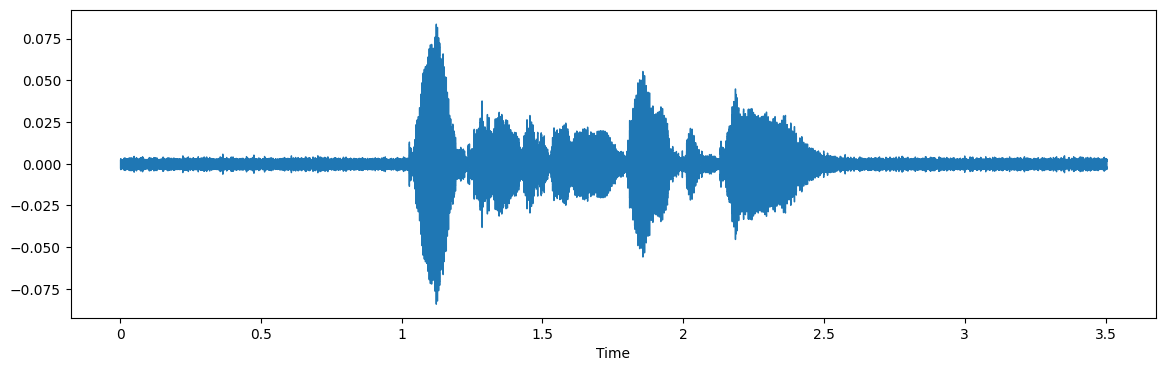

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.3 Stretching :

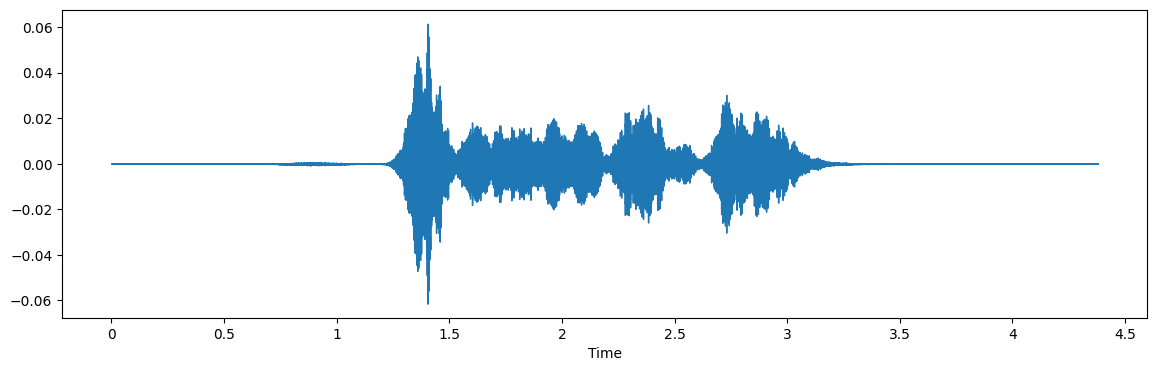

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.4 Shifting :

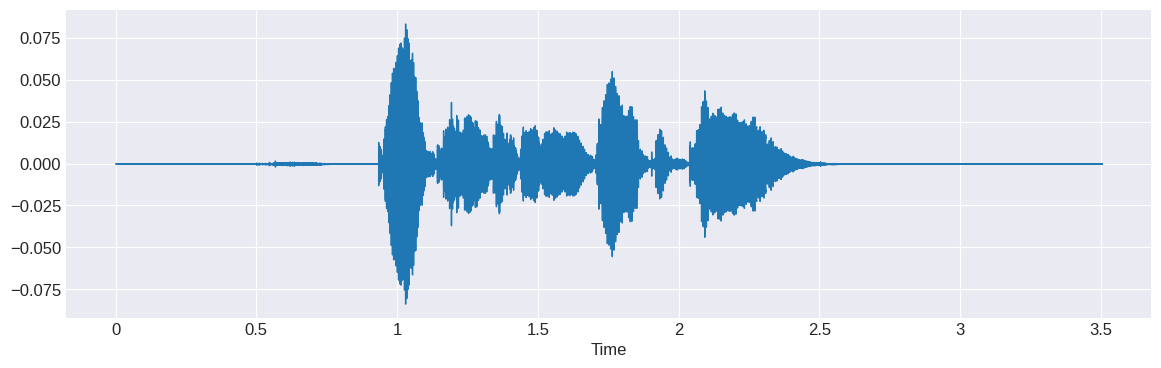

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.5 Pitch :

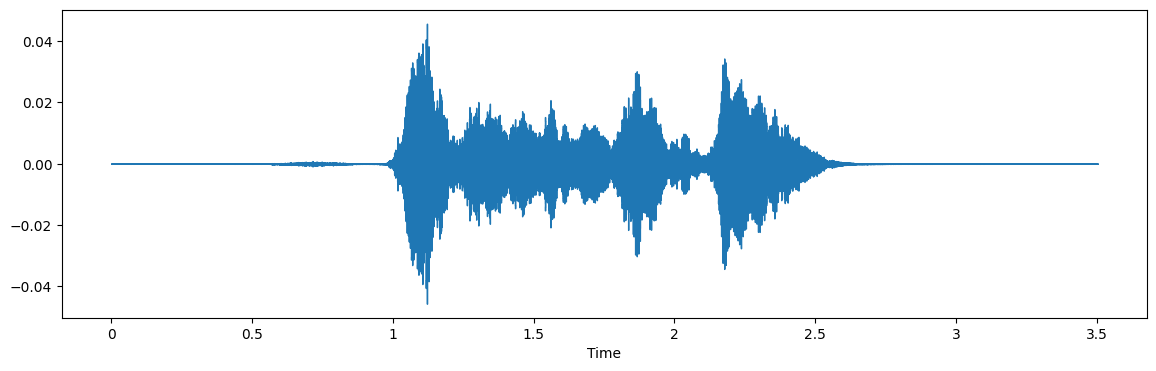

In [ ]:
x = pitch(data,sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

### 5 Feature Extraction :

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

### 6. Data Preperation

In [ ]:
#TAKES 7MINS TO RUN
X, Y = [], []
for path, emotion in zip(RAV_df.path, RAV_df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), RAV_df.path.shape

(4320, 4320, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [ ]:
display(Features.head())
display(Features.describe())

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.198559,0.535461,0.574463,0.587632,0.628334,0.618310,0.585882,0.632138,0.727193,0.727066,...,0.000134,0.000094,0.000093,0.000085,0.000116,0.000143,0.000152,0.000115,0.000012,surprise
1,0.317044,0.700338,0.739018,0.757217,0.799702,0.754420,0.655419,0.706682,0.758210,0.748509,...,0.001573,0.001630,0.001663,0.001576,0.001675,0.001654,0.001614,0.001707,0.001482,surprise
2,0.152474,0.554980,0.503629,0.546263,0.574463,0.624892,0.577142,0.590315,0.660629,0.752306,...,0.000032,0.000027,0.000020,0.000014,0.000016,0.000023,0.000023,0.000019,0.000001,surprise
3,0.219817,0.541381,0.525216,0.587649,0.588066,0.616600,0.621537,0.618771,0.609503,0.610464,...,0.000312,0.000313,0.000615,0.000293,0.000209,0.000273,0.000203,0.000085,0.000006,happy
4,0.224496,0.607155,0.562587,0.585053,0.625529,0.647622,0.676411,0.630420,0.630081,0.609400,...,0.000311,0.000314,0.000616,0.000293,0.000209,0.000272,0.000204,0.000086,0.000006,happy


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
count,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,...,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03
mean,0.210779,0.628072,0.631271,0.636034,0.645899,0.635100,0.606720,0.601117,0.619854,0.637192,...,1.819423e-03,1.828672e-03,1.868830e-03,1.902502e-03,1.959903e-03,1.993904e-03,1.985472e-03,1.952049e-03,1.450112e-03,8.196774e-04
std,0.068781,0.087540,0.097234,0.100186,0.101951,0.104625,0.091860,0.079101,0.080722,0.079190,...,6.489321e-03,6.501569e-03,6.657941e-03,6.817174e-03,7.171533e-03,7.222313e-03,7.068690e-03,6.842537e-03,5.732237e-03,4.714979e-03
min,0.060091,0.339261,0.287325,0.274444,0.261164,0.263645,0.269483,0.262952,0.242572,0.269638,...,2.135293e-08,1.692828e-08,2.129181e-08,2.400353e-08,2.899570e-08,2.325147e-08,6.041341e-08,7.742907e-08,3.496952e-08,2.159540e-09
25%,0.154509,0.569156,0.565742,0.566488,0.576435,0.565715,0.549633,0.554086,0.568618,0.585646,...,2.878016e-05,2.968341e-05,3.031001e-05,3.169590e-05,3.509130e-05,3.443391e-05,3.452951e-05,3.342971e-05,2.012565e-05,1.952608e-06
50%,0.201867,0.632175,0.635916,0.641409,0.652827,0.643294,0.615989,0.609684,0.625884,0.643685,...,1.683180e-04,1.671254e-04,1.689268e-04,1.786096e-04,1.845056e-04,1.823518e-04,1.868251e-04,1.852173e-04,1.148990e-04,1.451322e-05
75%,0.266736,0.691233,0.701426,0.708977,0.720506,0.708755,0.670723,0.656287,0.677834,0.693470,...,8.574596e-04,8.621011e-04,9.322014e-04,9.086306e-04,9.256718e-04,9.295054e-04,9.296110e-04,9.211846e-04,5.864765e-04,1.078983e-04
max,0.394793,0.855790,0.867839,0.899336,0.912413,0.905247,0.882090,0.813966,0.825857,0.868190,...,1.116106e-01,1.112137e-01,1.171255e-01,1.052672e-01,1.242990e-01,1.169212e-01,1.116897e-01,1.187567e-01,9.408667e-02,8.643418e-02


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 7), (1080, 162, 1), (1080, 7))

### 7. Modelling :

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 81, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 81, 128)           163968    
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 41, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 41, 64)            41024     
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 21, 64)           

### 8. Training :

In [ ]:
#takes 10mins
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 15s 236ms/step - loss: 1.8986 - accuracy: 0.2340 - val_loss: 1.8237 - val_accuracy: 0.2935 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 12s 237ms/step - loss: 1.8425 - accuracy: 0.2716 - val_loss: 1.7603 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 10s 196ms/step - loss: 1.7838 - accuracy: 0.2926 - val_loss: 1.7293 - val_accuracy: 0.3213 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 11s 212ms/step - loss: 1.7365 - accuracy: 0.3173 - val_loss: 1.6907 - val_accuracy: 0.3537 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 12s 229ms/step - loss: 1.6927 - accuracy: 0.3340 - val_loss: 1.6459 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 13s 263ms/step - loss: 1.6682 - accuracy: 0.3355 - val_loss: 1.6119 - val_accuracy: 0.4093 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 11s 214ms/st

### 9. Evaluation :

34/34 [==============================] - 1s 22ms/step - loss: 1.1247 - accuracy: 0.6222
Accuracy of our model on test data :  62.22222447395325 %


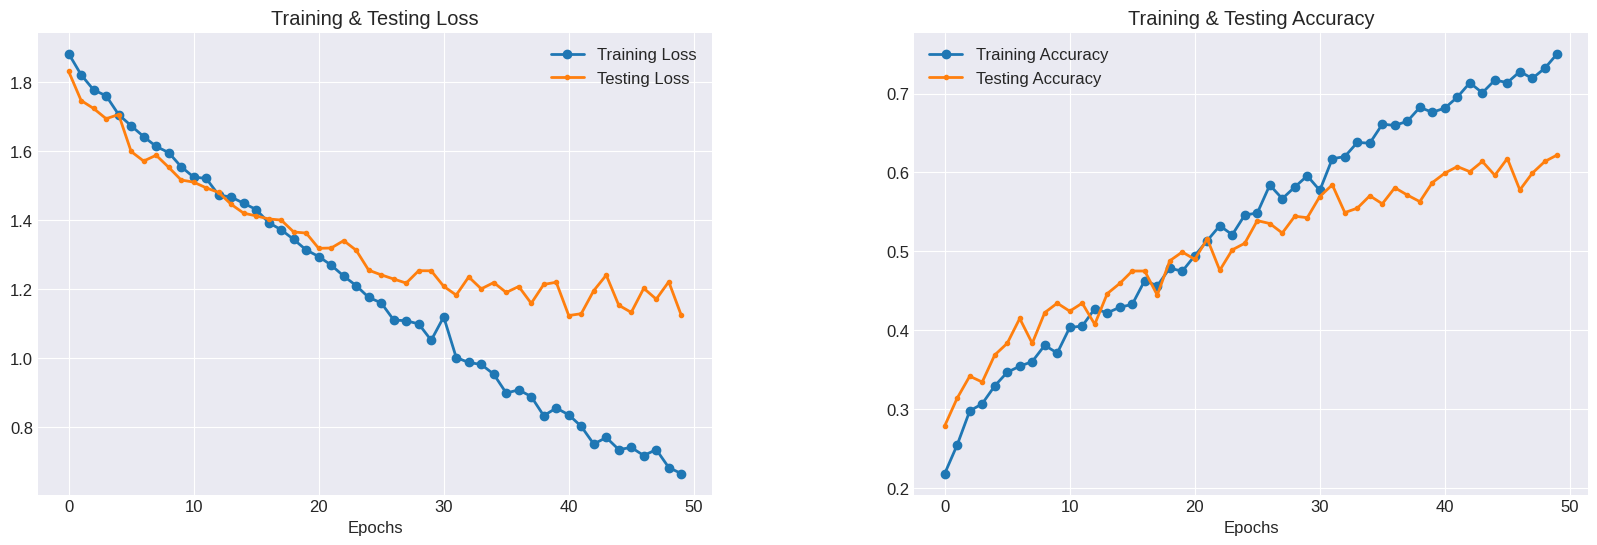

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=2)
ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=2)
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 22ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

display(df.head())

,Predicted Labels,Actual Labels
0,sad,sad
1,angry,angry
2,disgust,disgust
3,surprise,fear
4,sad,neutral


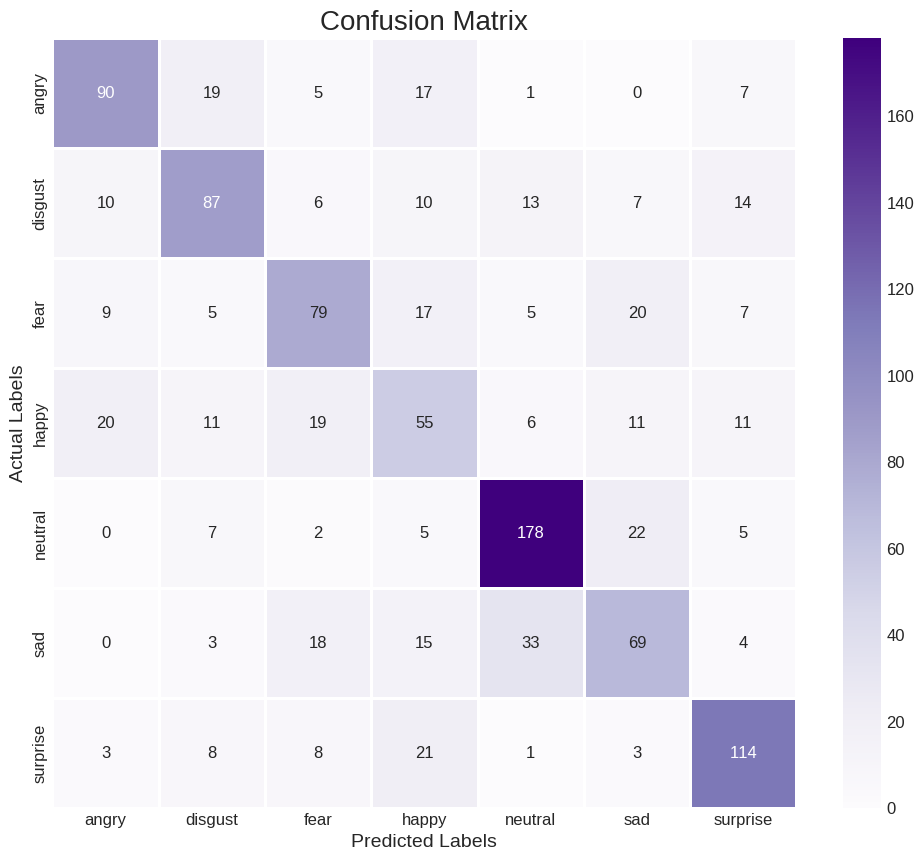

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.68      0.65      0.66       139
     disgust       0.62      0.59      0.61       147
        fear       0.58      0.56      0.57       142
       happy       0.39      0.41      0.40       133
     neutral       0.75      0.81      0.78       219
         sad       0.52      0.49      0.50       142
    surprise       0.70      0.72      0.71       158

    accuracy                           0.62      1080
   macro avg       0.61      0.60      0.61      1080
weighted avg       0.62      0.62      0.62      1080



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 81, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 128)           163968    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 41, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 64)            41024     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 21, 64)           

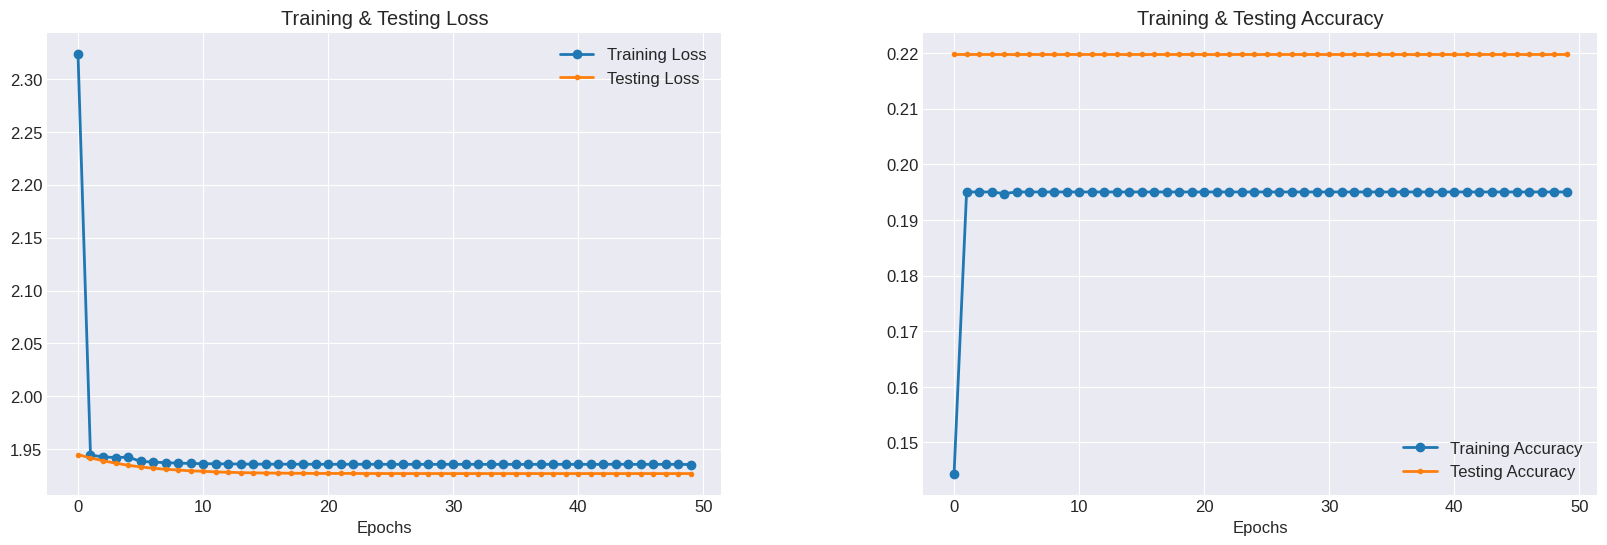

Accuracy of Random Forest on test data:  39.23611111111111 %
Confusion Matrix:
 [[112   0   0   0   0   0   0]
 [ 94  19   0   0   2   0   0]
 [ 84   0  31   0   0   0   0]
 [ 88   0   0  14   1   0   0]
 [ 64   0   0   0 126   0   0]
 [ 87   0   0   0   9  20   0]
 [ 96   0   0   0   0   0  17]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Assuming get_features is a defined function to extract features from audio files.
# X and Y arrays for storing features and labels
X, Y = [], []

# Optimized data extraction
for path, emotion in zip(RAV_df.path, RAV_df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

# Converting lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# One-hot encoding the labels
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Reshape data for Conv1D
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# Building the Sequential model
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=7, activation='softmax'))

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callback for reducing learning rate
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=4, min_lr=0.0000001)

# Training the model
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

# Evaluating the model
accuracy = model.evaluate(x_test, y_test)[1] * 100
print("Accuracy of our model on test data: ", accuracy, "%")

# Plotting the training history
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

ax[0].plot(epochs, train_loss, label='Training Loss', marker='o', linewidth=2)
ax[0].plot(epochs, test_loss, label='Testing Loss', marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy', marker='o', linewidth=2)
ax[1].plot(epochs, test_acc, label='Testing Accuracy', marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

# Training Random Forest Classifier
# Reshape x_train and x_test for Random Forest
x_train_rf = x_train.squeeze()
x_test_rf = x_test.squeeze()

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(x_train_rf, y_train)

# Predicting and evaluating Random Forest
y_pred_rf = rf_clf.predict(x_test_rf)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred_rf, axis=1)

rf_accuracy = accuracy_score(y_test_labels, y_pred_labels) * 100
print("Accuracy of Random Forest on test data: ", rf_accuracy, "%")

# Confusion Matrix for Random Forest
cm = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:\n", cm)
